<a href="https://colab.research.google.com/github/tettey-exploits/pix2pix/blob/main/Pix2Pix_Image_to_Image_Translation_with_Conditional_Adversarial_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pix2Pix: Image-to-Image Translation with Conditional Adversarial Networks
-------------------------------------------------------------------------
In this notebook, we implement a generative model based on the paper
"Image-to-Image Translation with Conditional Adversarial Networks" by Isola et al. (2017),
commonly known as Pix2Pix. The model leverages conditional GANs (Generative Adversarial Networks)
for image-to-image translation tasks, where a model is trained to generate output images
based on input images. This approach works on tasks like image colorization, sketch to photo,
and satellite image to map transformation(which we focus on in this notebook), among others.

The Pix2Pix architecture consists of two key components:
1. Generator: A neural network that transforms input images into corresponding output images.
2. Discriminator: A network that evaluates how realistic the generated images are by distinguishing
   between real and fake images, which helps guide the generator's training.

In this notebook, we will walk through the implementation of the Pix2Pix model using PyTorch
and a dataset for training the generator and discriminator.


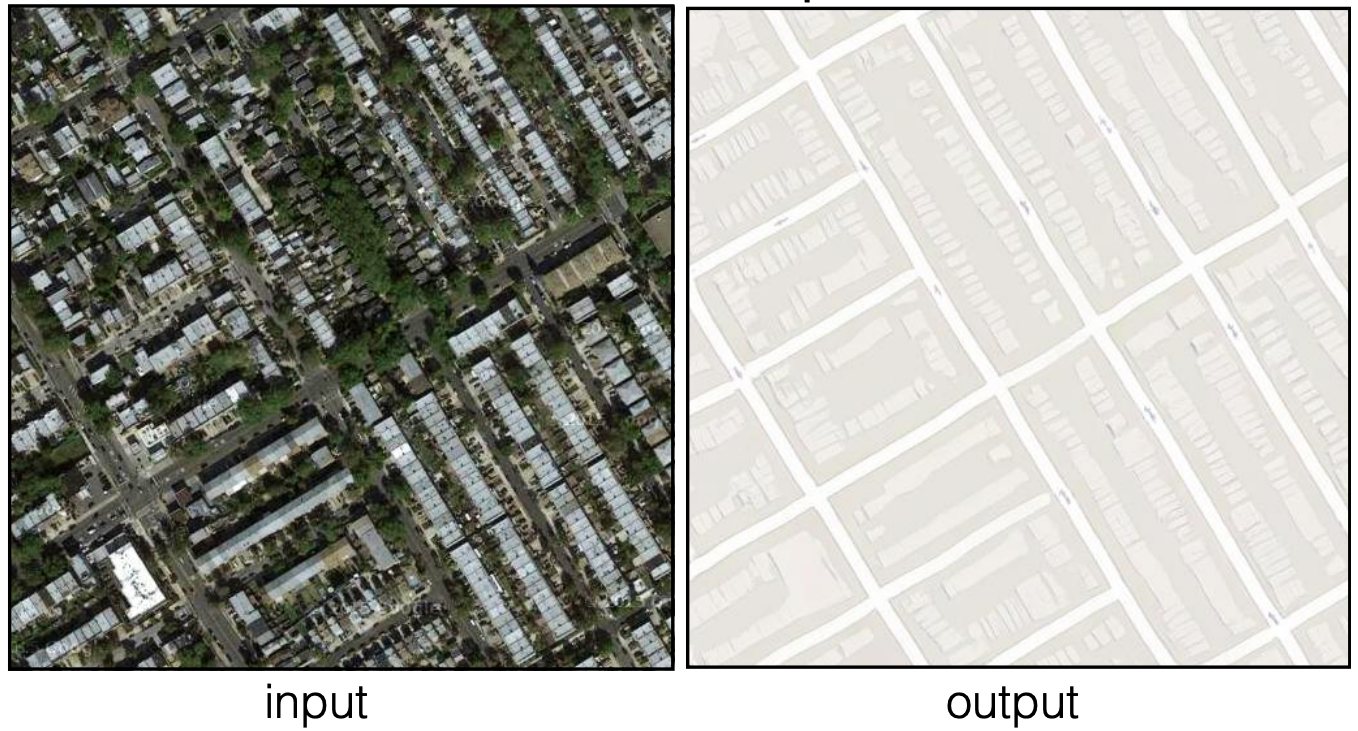


## Datasets
For training the Pix2Pix model, we require input-output pairs where each input image has a corresponding ground truth image. These pairs can represent a wide variety of tasks, such as image-to-image translation (e.g., converting sketches to photographs, or satellite images to map data). In this notebook, we focus on generating map transformations from satellite images.

You can find more paired images for more image generation tasks [here](https://efrosgans.eecs.berkeley.edu/pix2pix/datasets/)

In [1]:
import gdown

#download dataset
gdown.download("https://drive.google.com/file/d/13Nl231lNXdsZdGSUghLr8300af_G4fsv/view?usp=drive_link", "maps.tar.gz", quiet=False, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=13Nl231lNXdsZdGSUghLr8300af_G4fsv
From (redirected): https://drive.google.com/uc?id=13Nl231lNXdsZdGSUghLr8300af_G4fsv&confirm=t&uuid=29f4fb4f-4d3a-4eaa-94ee-5d7e5e23108a
To: /content/maps.tar.gz
100%|██████████| 255M/255M [00:04<00:00, 54.5MB/s]


'maps.tar.gz'

In [2]:
# extract the downloaded dataset
import tarfile

file = tarfile.open('/content/maps.tar.gz')
file.extractall('/content')
file.close()

In [3]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

### Helper Functions for Image Processing

These functions provide essential utilities for manipulating and visualizing image tensors, such as cropping images to a specific size and displaying a grid of images for visualization.

In [4]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [5]:
def crop(image, new_shape):
    '''
    Function for cropping an image tensor: Given an image tensor and the new shape,
    crops to the center pixels.
    Parameters:
        image: image tensor of shape (batch size, channels, height, width)
        new_shape: a torch.Size object with the shape you want x to have
    '''
    middle_height = image.shape[2] // 2
    middle_width = image.shape[3] // 2
    starting_height = middle_height - round(new_shape[2] / 2)
    final_height = starting_height + new_shape[2]
    starting_width = middle_width - round(new_shape[3] / 2)
    final_width = starting_width + new_shape[3]
    cropped_image = image[:, :, starting_height:final_height, starting_width:final_width]
    return cropped_image

## UNet Architecture

In *image-to-image translation*, the task involves mapping high-resolution input grids to high-resolution output grids, where the input and output images share underlying structures but differ in surface appearance. The UNet architecture is designed to address this by using skip connections that allow low-level details in the input to bypass the bottleneck, preserving important information such as edge locations. These skip connections link layers in the encoder with corresponding layers in the decoder, allowing for a more direct flow of shared information between the input and output, improving the quality and accuracy of the generated images.

**Components:**
*   **Upfeature Layer**: This layer maps the input image to the initial hidden channel size
*   **Contracting Blocks**: A series of `ContractingBlock` that reduce the spatial dimensions of the image while increasing the number of feature channels. These blocks progressively capture the image’s context.
*   **Expanding Blocks**: A series of `ExpandingBlock` that increase the spatial resolution of the feature map while decreasing the number of feature channels, using skip connections from the contracting path to retain important details.
*   **Downfeature Layer**: `FeatureMapBlock` is the final layer that maps the expanded feature map to the desired output channels.


During the forward pass, the input image is passed through the upfeature layer and multiple contracting blocks. It is then passed through the corresponding expanding blocks with skip connections from the contracting path. The output is passed through the downfeature layer and the sigmoid activation to produce the final segmented output.

### ContractingBlock: Encoder Building Block
The `ContractingBlock` class is a core component of the U-Net architecture, responsible for progressively reducing the spatial dimensions of the input image while increasing the number of feature channels. This block helps the model to learn more complex representations of the image at various scales.

**Components**:

- **Convolution Layers**: Two convolutional layers with ReLU activations that extract and refine features.
- **Batch Normalization (optional)**: Normalizes the output of the convolutional layers to stabilize learning.
- **Dropout (optional)**: Helps prevent overfitting by randomly dropping units during training.
- **Max Pooling**: Reduces the spatial size of the feature maps, allowing the network to focus on higher-level features.

**Purpose**: This block extracts and compresses spatial features from the input image, feeding them into the deeper layers of the network for further processing.

In [6]:
class ContractingBlock(nn.Module):
    '''
    ContractingBlock Class
    Performs two convolutions followed by a max pool operation.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, use_dropout=False, use_bn=True):
        super(ContractingBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels * 2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(input_channels * 2, input_channels * 2, kernel_size=3, padding=1)
        self.activation = nn.LeakyReLU(0.2)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        if use_bn:
            self.batchnorm = nn.BatchNorm2d(input_channels * 2)
        self.use_bn = use_bn
        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self, x):
        '''
        Function for completing a forward pass of ContractingBlock:
        Given an image tensor, completes a contracting block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv1(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.conv2(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.maxpool(x)
        return x

## ExpandingBlock: Decoder Building Block

The `ExpandingBlock` class is a key component in the **U-Net** architecture, responsible for the **upsampling** and subsequent feature refinement in the image generation process, typically in Pix2Pix.

It generates an output image from an input image, often with transformations like adding color or texture. After a series of **contracting blocks** that progressively extract features from the input, the **expanding blocks** are responsible for **upsampling** the feature map back to the original image dimensions while refining the features. This helps the model generate detailed output images that are spatially aligned with the input.


**Components**:

- **Upsampling**: The input feature map is upsampled using bilinear interpolation to increase the spatial dimensions. This is necessary to recover the original resolution of the image while retaining the learned features.
  
- **Convolutions**: After upsampling, the feature map passes through a series of convolutions (conv1, conv2, conv3) that refine the spatial features learned in the contracting path. The convolution layers help capture detailed spatial patterns and further process the upsampled data.

- **Skip Connection**: The skip connection from the corresponding layer in the contracting path is concatenated with the upsampled feature map. This ensures that fine-grained details from earlier layers (that might be lost during downsampling) are preserved and propagated in the final output.

- **Batch Normalization**: Optional batch normalization is used to stabilize the training process by normalizing the feature maps after convolutions. This helps improve training performance and convergence.

- **Dropout**: Dropout is applied optionally, providing regularization during training to prevent overfitting. It randomly zeros out certain activations, encouraging the model to generalize better.

- **Activation**: A ReLU activation function is applied after each convolution to introduce non-linearity and enable the model to learn more complex patterns.


In the forward pass, the input tensor is first upsampled, passed through convolution layers (with skip connections from the contracting path), and processed with optional batch normalization, dropout, and activation functions. The result is an expanded feature map that progressively refines the image generation.

In [7]:

class ExpandingBlock(nn.Module):
    '''
    ExpandingBlock Class:
    Performs an upsampling, a convolution, a concatenation of its two inputs,
    followed by two more convolutions with optional dropout
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, use_dropout=False, use_bn=True):
        super(ExpandingBlock, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=2)
        self.conv2 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(input_channels // 2, input_channels // 2, kernel_size=2, padding=1)
        if use_bn:
            self.batchnorm = nn.BatchNorm2d(input_channels // 2)
        self.use_bn = use_bn
        self.activation = nn.ReLU()
        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self, x, skip_con_x):
        '''
        Function for completing a forward pass of ExpandingBlock:
        Given an image tensor, completes an expanding block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
            skip_con_x: the image tensor from the contracting path (from the opposing block of x)
                    for the skip connection
        '''
        x = self.upsample(x)
        x = self.conv1(x)
        skip_con_x = crop(skip_con_x, x.shape)
        x = torch.cat([x, skip_con_x], axis=1)
        x = self.conv2(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.conv3(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        return x


## FeatureMapBlock

The `FeatureMapBlock` class is a crucial component in the **Pix2Pix** model, typically used as the final layer in the architecture. It maps each pixel of the image to the appropriate output dimensions using a 1x1 convolution.


It generates an image conditioned on another image (e.g., transforming a sketch into a photo). The output image needs to have the same spatial dimensions as the input but with a different number of channels, depending on the specific task (such as generating a color image from a grayscale one).

The `FeatureMapBlock` ensures that the final output has the exact number of channels required for the task (e.g., 3 channels for RGB images or 1 channel for grayscale images).

**Components**:

- **1x1 Convolution**: The 1x1 convolution layer is applied to the feature map to adjust the number of channels without altering the spatial dimensions of the image. This is important because the Pix2Pix architecture generates images where the output size must match the input size, and a change in channels is necessary for the final transformation.
  

**Forward Pass**: The image tensor is passed through the `FeatureMapBlock`, where the 1x1 convolution maps the feature map to the desired number of output channels. This allows the model to output an image with the correct depth for the target task, completing the image transformation process.

In [8]:
class FeatureMapBlock(nn.Module):
    '''
    FeatureMapBlock Class
    The final layer of a U-Net -
    maps each pixel to a pixel with the correct number of output dimensions
    using a 1x1 convolution.
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=1)

    def forward(self, x):
        '''
        Function for completing a forward pass of FeatureMapBlock:
        Given an image tensor, returns it mapped to the desired number of channels.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv(x)
        return x

In [9]:
class UNet(nn.Module):
    '''
    UNet Class
    A series of 4 contracting blocks followed by 4 expanding blocks to
    transform an input image into the corresponding paired image, with an upfeature
    layer at the start and a downfeature layer at the end.
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels, hidden_channels=32):
        super(UNet, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_dropout=True)
        self.contract2 = ContractingBlock(hidden_channels * 2, use_dropout=True)
        self.contract3 = ContractingBlock(hidden_channels * 4, use_dropout=True)
        self.contract4 = ContractingBlock(hidden_channels * 8)
        self.contract5 = ContractingBlock(hidden_channels * 16)
        self.contract6 = ContractingBlock(hidden_channels * 32)
        self.expand0 = ExpandingBlock(hidden_channels * 64)
        self.expand1 = ExpandingBlock(hidden_channels * 32)
        self.expand2 = ExpandingBlock(hidden_channels * 16)
        self.expand3 = ExpandingBlock(hidden_channels * 8)
        self.expand4 = ExpandingBlock(hidden_channels * 4)
        self.expand5 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        '''
        Function for completing a forward pass of UNet:
        Given an image tensor, passes it through U-Net and returns the output.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        x5 = self.contract5(x4)
        x6 = self.contract6(x5)
        x7 = self.expand0(x6, x5)
        x8 = self.expand1(x7, x4)
        x9 = self.expand2(x8, x3)
        x10 = self.expand3(x9, x2)
        x11 = self.expand4(x10, x1)
        x12 = self.expand5(x11, x0)
        xn = self.downfeature(x12)
        return self.sigmoid(xn)

## PatchGAN Discriminator

In image generation tasks, traditional loss functions like L2 and L1 often produce blurry results, especially when high-frequency details are important. To address this, the PatchGAN discriminator is designed to focus on high-frequency structures by classifying whether each N×N patch in the image is real or fake. This method allows the discriminator to model local image details, which are crucial for capturing sharp features, while relying on the L1 loss to enforce low-frequency correctness. The PatchGAN is computationally efficient due to its smaller size and fewer parameters, and it treats the image as a Markov random field, where pixel independence is assumed beyond the patch size, making it effective for modeling textures and styles.


**Components**:

*   Upfeature Layer: The input image is processed and transformed to match the initial hidden channel size.
*   Contracting Path: Consists of multiple contracting blocks, each reducing the spatial size of the image while increasing the number of feature channels. It progressively learns spatial features from the image.
*   Final Convolution Layer: A 1x1 convolution is applied to output a score for each patch, indicating whether it's real or fake.

The PatchGAN discriminator processes an image (real or generated) through a convolutional network, outputting a matrix of predictions, where each element corresponds to whether a specific 𝑁×𝑁 patch of the image is real or fake.




In [10]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Structured like the contracting path of the U-Net, the discriminator will
    output a matrix of values classifying corresponding portions of the image as real or fake.
    Parameters:
        input_channels: the number of image input channels
        hidden_channels: the initial number of discriminator convolutional filters
    '''
    def __init__(self, input_channels, hidden_channels=8):
        super(Discriminator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_bn=False)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        self.contract3 = ContractingBlock(hidden_channels * 4)
        self.contract4 = ContractingBlock(hidden_channels * 8)
        self.final = nn.Conv2d(hidden_channels * 16, 1, kernel_size=1)

    def forward(self, x, y):
        x = torch.cat([x, y], axis=1)
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        xn = self.final(x4)
        return xn

## Pix2Pix Training

*   Define Hyperparameters
*   Define Image Transformations and Load Dataset
*   Initialize Generator and Discriminator Models, Optimizers, and Weight Initialization
*   Define Loss Functions
*   Model Training



### Define Hyperparameters

In [11]:
import torch.nn.functional as F  # Importing PyTorch's functional API for various operations like activation functions
import torchvision  # Importing the torchvision library

# New parameters for model training and configuration
adv_criterion = nn.BCEWithLogitsLoss()  # Adversarial loss function (Binary Cross-Entropy with logits) for the generator and discriminator
recon_criterion = nn.L1Loss()  # Reconstruction loss function (L1 loss) for the generator to compare generated vs. real images
lambda_recon = 200  # Weighting factor for balancing adversarial loss and reconstruction loss

n_epochs = 20  # Number of epochs for training the model
input_dim = 3  # Number of input channels for the generator (e.g., RGB image has 3 channels)
real_dim = 3  # Number of output channels for the generator (e.g., RGB image has 3 channels)
display_step = 200  # Frequency (in steps) at which to display results or print loss
batch_size = 4  # Number of samples per batch used in training
lr = 0.0002  # Learning rate for optimizer, controlling the update size of the model's weights
target_shape = 256  # Desired shape of the output image (height and width) from the generator
device = 'cuda'  # Specifies the device for computation (using CUDA for GPU acceleration)


### Define Image Transformations and Load Dataset


In [12]:
# Define a transformation pipeline to convert images to tensors
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts the images into PyTorch tensors, scaling pixel values to [0, 1] range
])

# Load the dataset from the "maps" directory
dataset = torchvision.datasets.ImageFolder("maps", transform=transform)  # Loads images from the "maps" folder with the defined transform

### Initialize Generator and Discriminator Models, Optimizers, and Weight Initialization

In [13]:
"""Initialize the generator (UNet) model with input and output dimensionsThe generator
takes the input dimension (e.g., 3 for RGB images) and produces output with the same dimensions as the real images"""
gen = UNet(input_dim, real_dim).to(device)  # Move the model to the specified device (CUDA or CPU)

# Set up the optimizer for the generator (Adam optimizer with a specified learning rate)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)

""" Initialize the discriminator model. The discriminator takes both the generated
images and real images as input, hence input dimension is input_dim + real_dim """
disc = Discriminator(input_dim + real_dim).to(device)  # Move the discriminator to the specified device

# Set up the optimizer for the discriminator (Adam optimizer with a specified learning rate)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)


In [14]:
# Function to initialize the weights of the model layers
def weights_init(m):
    # Initialize Conv2d and ConvTranspose2d layers with a normal distribution
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02) # mean = 0.0, standard deviation 0.02

    # Initialize BatchNorm2d layers with a normal distribution and set bias to 0
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02) # mean = 0.0, standard deviation 0.02
        # Initialize the bias to 0 for Batch Normalization layers
        torch.nn.init.constant_(m.bias, 0)


In [15]:
# Flag to determine if we should load pretrained weights or initialize from scratch
pretrained = False

# If pretrained is True, load weights from a checkpoint, otherwise initialize weights randomly
if pretrained:
    # Load pre-trained model weights and optimizer states
    loaded_state = torch.load("pix2pix_15000.pth")
    gen.load_state_dict(loaded_state["gen"])
    gen_opt.load_state_dict(loaded_state["gen_opt"])
    disc.load_state_dict(loaded_state["disc"])
    disc_opt.load_state_dict(loaded_state["disc_opt"])
else:
    # Initialize generator and discriminator with custom weights
    gen = gen.apply(weights_init)
    disc = disc.apply(weights_init)


### Define Loss Functions
We define a function `get_gen_loss` that computes the loss for the generator in a generative adversarial network (GAN) setup with image-to-image translation. It combines adversarial loss and reconstruction loss to guide the generator toward creating high-quality outputs that resemble real images. Here's how it works:


*   **Adversarial Loss (`adv_criterion`):** This loss ensures the generator creates images that are indistinguishable from real images by the discriminator. It is typically defined as the negative log likelihood of the discriminator predicting the generated images as real.

*   **Reconstruction  (`recon_criterion`):** This loss measures how closely the generated images match the real target images. It ensures the generator produces images that retain important details, typically using L1 or L2 loss to compare the generated image with the real one.






In [16]:
def get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator; takes the condition and returns potential images
        disc: the discriminator; takes images and the condition and
          returns real/fake prediction matrices
        real: the real images (e.g. maps) to be used to evaluate the reconstruction
        condition: the source images (e.g. satellite imagery) which are used to produce the real images
        adv_criterion: the adversarial loss function; takes the discriminator
                  predictions and the true labels and returns a adversarial
                  loss (which you aim to minimize)
        recon_criterion: the reconstruction loss function; takes the generator
                    outputs and the real images and returns a reconstructuion
                    loss (which you aim to minimize)
        lambda_recon: the degree to which the reconstruction loss should be weighted in the sum
    '''

    gen_images = gen(condition)
    disc_pred = disc(gen_images, condition)
    ones = torch.ones(disc_pred.shape).to("cuda")
    adv_loss = adv_criterion(disc_pred.to("cuda"), ones)
    recon_loss = recon_criterion(gen_images, real)
    gen_loss = adv_loss + lambda_recon * recon_loss
    return gen_loss



  0%|          | 0/549 [00:00<?, ?it/s]

Pretrained initial state


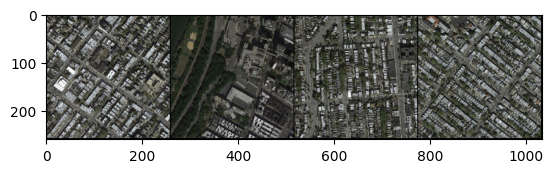

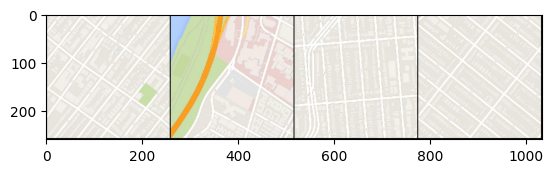

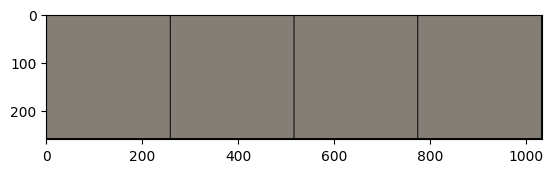

Epoch 0: Step 200: Generator (U-Net) loss: 75.99509813308723, Discriminator loss: 0.6475894665718076


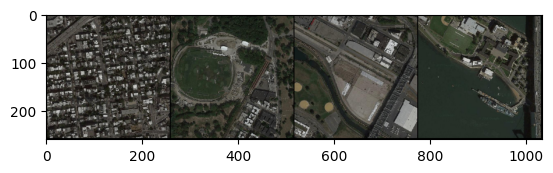

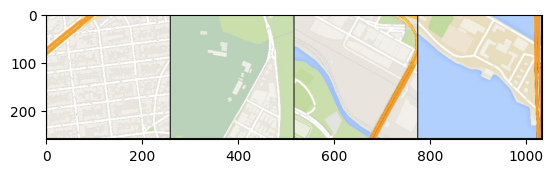

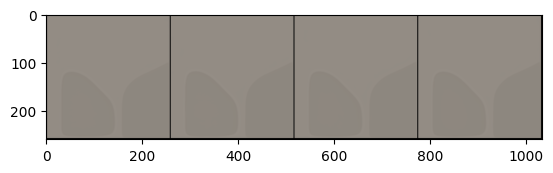

Epoch 0: Step 400: Generator (U-Net) loss: 59.973153114318855, Discriminator loss: 0.439244577437639


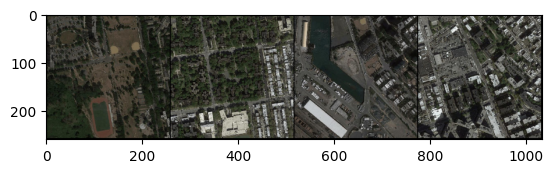

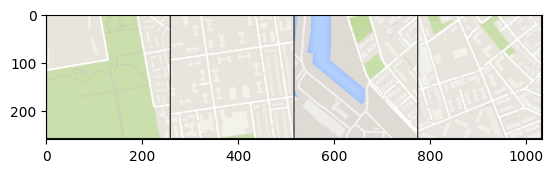

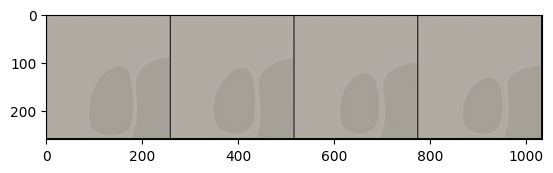

  0%|          | 0/549 [00:00<?, ?it/s]

Epoch 1: Step 600: Generator (U-Net) loss: 35.26626514434813, Discriminator loss: 0.4569410435855389


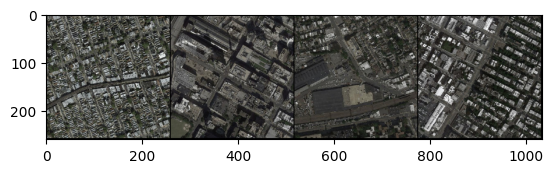

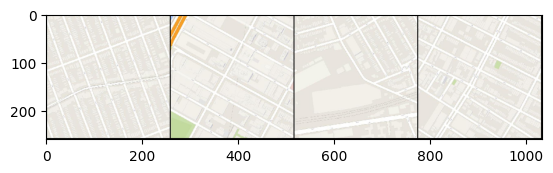

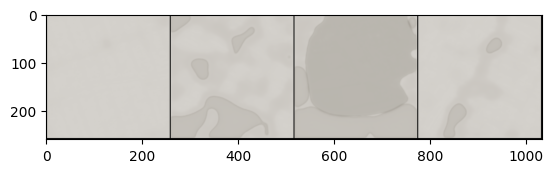

Epoch 1: Step 800: Generator (U-Net) loss: 17.46783026218415, Discriminator loss: 0.58500819966197


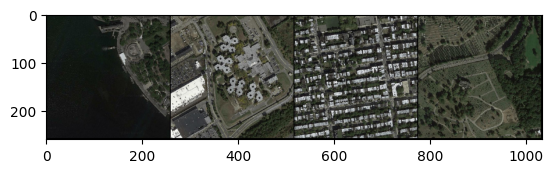

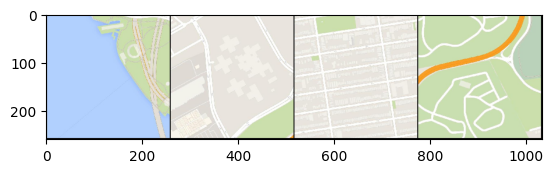

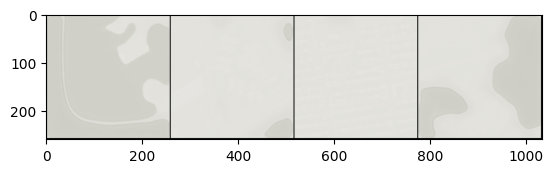

Epoch 1: Step 1000: Generator (U-Net) loss: 13.2416858625412, Discriminator loss: 0.18679353412240757


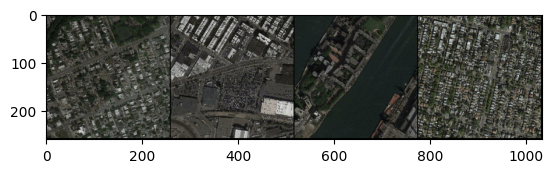

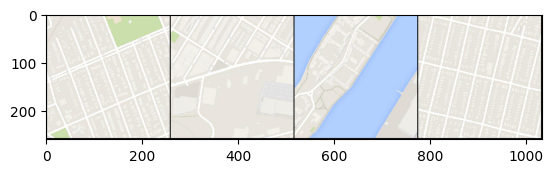

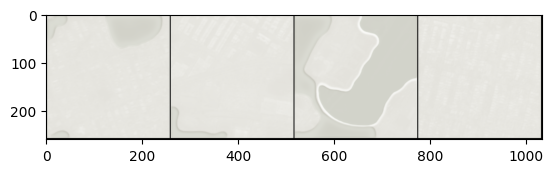

  0%|          | 0/549 [00:00<?, ?it/s]

Epoch 2: Step 1200: Generator (U-Net) loss: 13.399995994567862, Discriminator loss: 0.3033664055913686


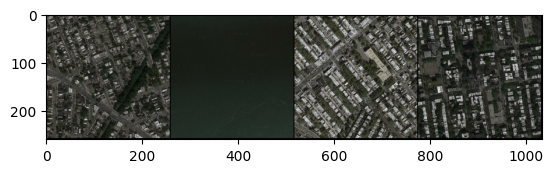

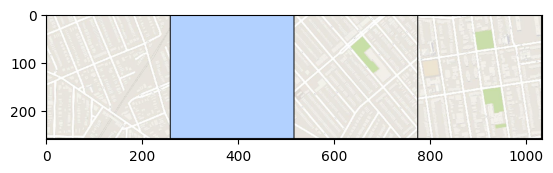

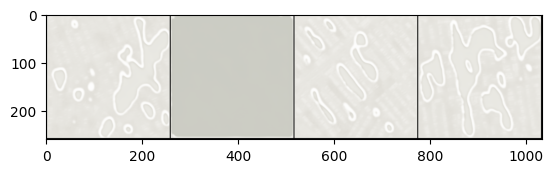

Epoch 2: Step 1400: Generator (U-Net) loss: 13.612035169601436, Discriminator loss: 0.15054607998579736


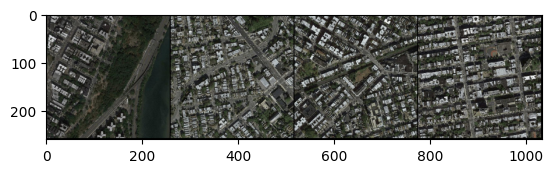

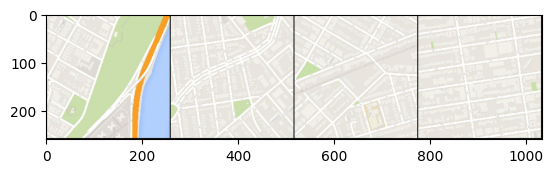

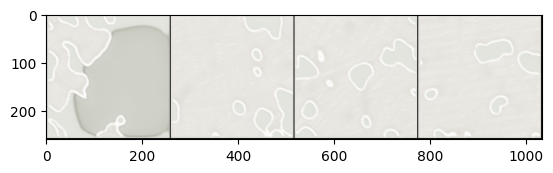

Epoch 2: Step 1600: Generator (U-Net) loss: 13.970094494819639, Discriminator loss: 0.2987036416307091


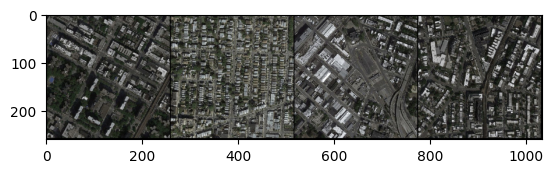

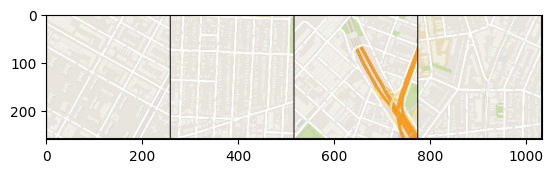

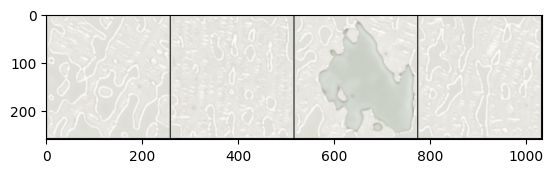

  0%|          | 0/549 [00:00<?, ?it/s]

Epoch 3: Step 1800: Generator (U-Net) loss: 13.861891994476327, Discriminator loss: 0.08547997403889888


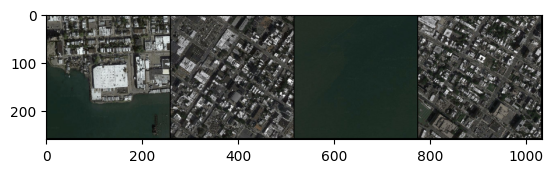

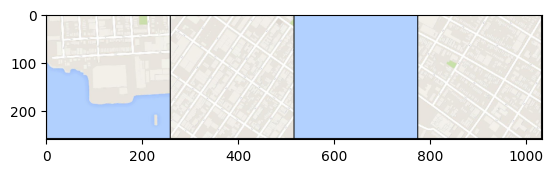

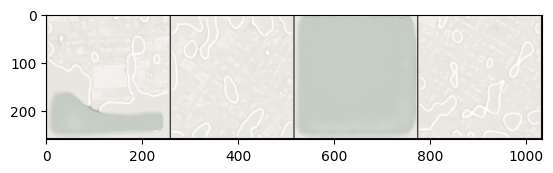

Epoch 3: Step 2000: Generator (U-Net) loss: 14.21865025997162, Discriminator loss: 0.06544220064766709


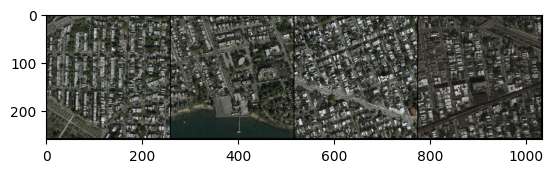

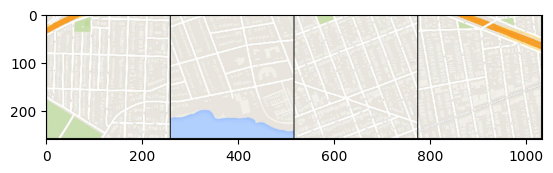

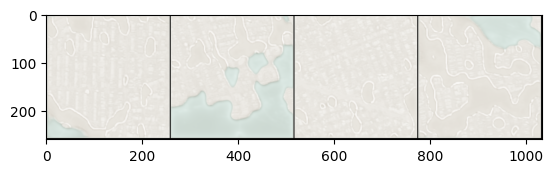

  0%|          | 0/549 [00:00<?, ?it/s]

Epoch 4: Step 2200: Generator (U-Net) loss: 13.689538578987126, Discriminator loss: 0.14510199189186093


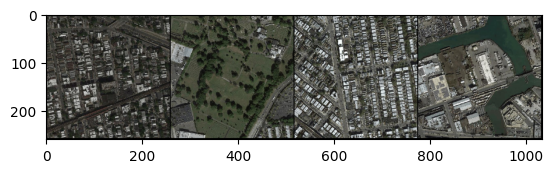

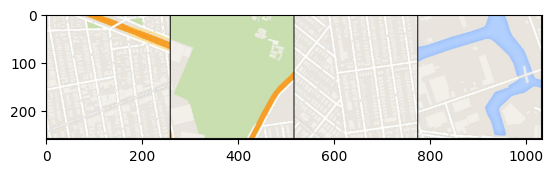

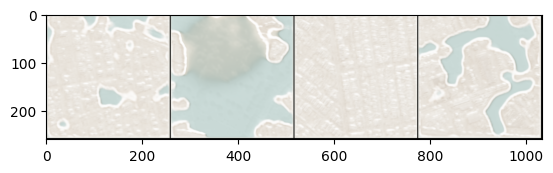

Epoch 4: Step 2400: Generator (U-Net) loss: 14.078587760925297, Discriminator loss: 0.054244001582264875


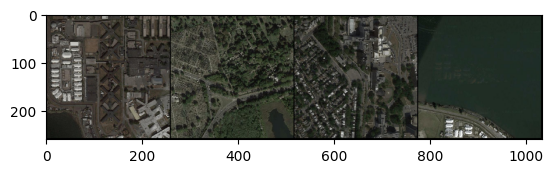

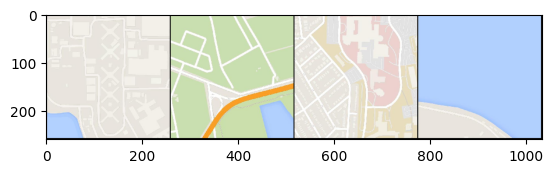

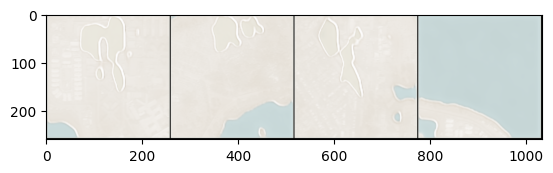

Epoch 4: Step 2600: Generator (U-Net) loss: 14.15610305309295, Discriminator loss: 0.05800335058942436


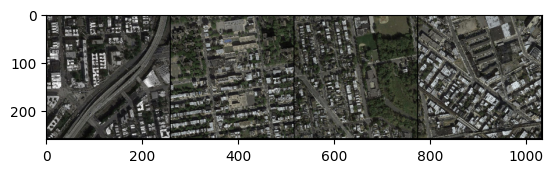

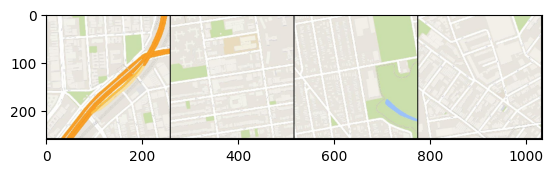

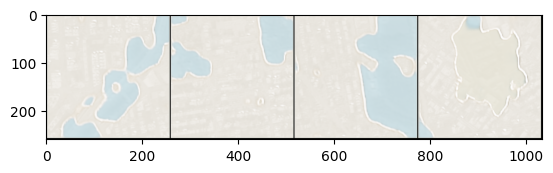

  0%|          | 0/549 [00:00<?, ?it/s]

Epoch 5: Step 2800: Generator (U-Net) loss: 14.29464111328125, Discriminator loss: 0.044835292464122184


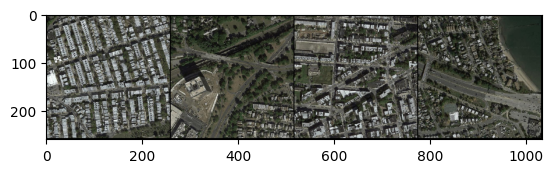

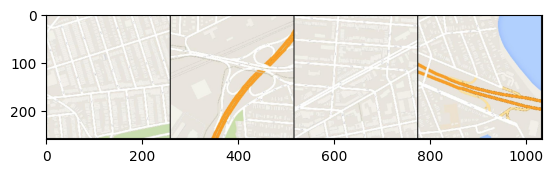

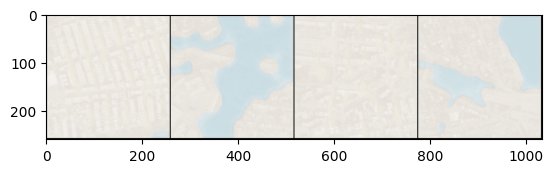

Epoch 5: Step 3000: Generator (U-Net) loss: 14.52626611232758, Discriminator loss: 0.09724906218703837


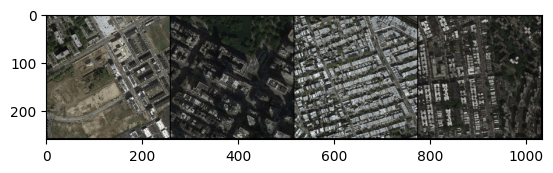

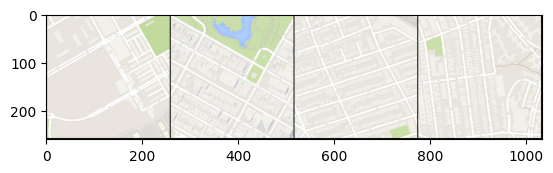

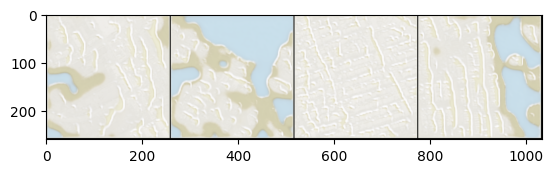

Epoch 5: Step 3200: Generator (U-Net) loss: 13.403263473510753, Discriminator loss: 0.23404946969822044


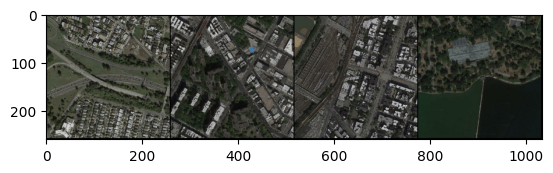

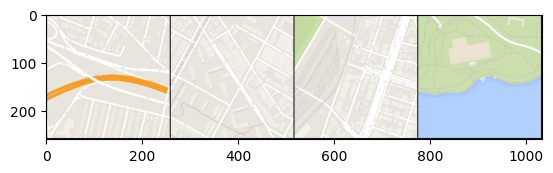

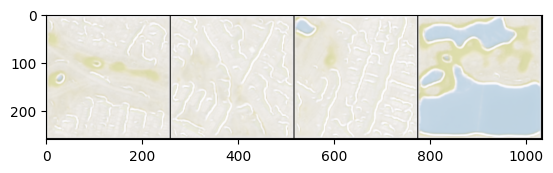

In [ ]:
from skimage import color
import numpy as np

def train(save_model=False):
    # Initialize average loss trackers
    mean_generator_loss = 0
    mean_discriminator_loss = 0

    # Create a DataLoader to load the dataset in batches
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    cur_step = 0  # Initialize current training step

    # Iterate through epochs
    for epoch in range(n_epochs):
        # Iterate through batches in the dataloader
        for image, _ in tqdm(dataloader):
            # Split the image into 'condition' (input) and 'real' (target) images
            image_width = image.shape[3]
            condition = image[:, :, :, :image_width // 2]
            condition = nn.functional.interpolate(condition, size=target_shape)
            real = image[:, :, :, image_width // 2:]
            real = nn.functional.interpolate(real, size=target_shape)

            cur_batch_size = len(condition)
            condition = condition.to(device)  # Move condition to device (GPU/CPU)
            real = real.to(device)  # Move real images to device (GPU/CPU)

            ### Update discriminator ###
            disc_opt.zero_grad()  # Zero out the gradient for the discriminator optimizer

            # Generate fake images using the generator (no gradient computation)
            with torch.no_grad():
                fake = gen(condition)

            # Get discriminator predictions for fake and real images
            disc_fake_hat = disc(fake.detach(), condition)  # Detach generator to avoid backpropagation to it
            disc_fake_loss = adv_criterion(disc_fake_hat, torch.zeros_like(disc_fake_hat))  # Loss for fake images

            disc_real_hat = disc(real, condition)  # Real images passed through discriminator
            disc_real_loss = adv_criterion(disc_real_hat, torch.ones_like(disc_real_hat))  # Loss for real images

            # Total discriminator loss is the average of real and fake losses
            disc_loss = (disc_fake_loss + disc_real_loss) / 2
            disc_loss.backward(retain_graph=True)  # Backpropagate the discriminator loss
            disc_opt.step()  # Update discriminator weights

            ### Update generator ###
            gen_opt.zero_grad()  # Zero out the gradient for the generator optimizer

            # Compute the generator loss (adversarial + reconstruction losses)
            gen_loss = get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon)
            gen_loss.backward()  # Backpropagate the generator loss
            gen_opt.step()  # Update generator weights

            # Track average generator and discriminator losses for visualization
            mean_discriminator_loss += disc_loss.item() / display_step
            mean_generator_loss += gen_loss.item() / display_step

            ### Visualization code ###
            # Display images every 'display_step' iterations
            if cur_step % display_step == 0:
                if cur_step > 0:
                    # Print average loss values for this step
                    print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
                else:
                    print("Pretrained initial state")

                # Visualize the input, real, and generated images
                show_tensor_images(condition, size=(input_dim, target_shape, target_shape))
                show_tensor_images(real, size=(real_dim, target_shape, target_shape))
                show_tensor_images(fake, size=(real_dim, target_shape, target_shape))

                # Reset the loss averages for the next display
                mean_generator_loss = 0
                mean_discriminator_loss = 0

                # Optionally save the model after the display step
                if save_model:
                    torch.save({
                        'gen': gen.state_dict(),
                        'gen_opt': gen_opt.state_dict(),
                        'disc': disc.state_dict(),
                        'disc_opt': disc_opt.state_dict()
                    }, f"pix2pix_{cur_step}.pth")

            cur_step += 1  # Increment the training step counter

# Call the training function to start training the model
train()


In [ ]:
# Save the model state dictionaries and optimizer states
torch.save({
    'gen': gen.state_dict(),  # Save the generator's state_dict
    'gen_opt': gen_opt.state_dict(),  # Save the generator's optimizer state_dict
    'disc': disc.state_dict(),  # Save the discriminator's state_dict
    'disc_opt': disc_opt.state_dict()  # Save the discriminator's optimizer state_dict
}, 'pix2pix_15000.pth')  # Save to the specified file


## "Congratulations! You've successfully trained and saved your Pix2Pix model!